# Data Preparation

## Problem Set Up

In [15]:
import numpy as np
import seaborn as sns
import pandas as pd

In [11]:
bank = pd.read_csv('bank.csv', delimiter=';')
bank.sample(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
1276,41,management,divorced,tertiary,no,5037,no,no,cellular,23,apr,252,9,185,5,other,yes
1751,48,management,divorced,secondary,no,1598,yes,no,unknown,29,may,84,1,-1,0,unknown,no
1468,38,management,married,tertiary,no,0,yes,no,cellular,13,may,537,5,303,2,failure,no


```
bank['age']  vs bank[['age']]
```

In [19]:
X = bank[ ['age', 'balance']].values # extracts underlying numpy

In [20]:
y = bank['y'].values
y[ y == 'yes' ] = 1
y[ y == 'no' ] = 0

In [21]:
np.unique(y, return_counts=True)

(array([0, 1], dtype=object), array([4000,  521], dtype=int64))

In [41]:
1 - 521/4000

0.86975

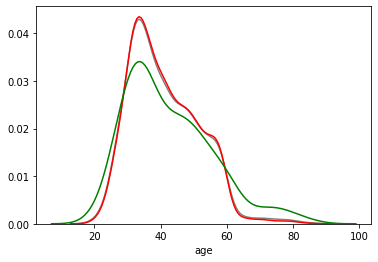

In [138]:
sns.distplot(bank.loc[:, 'age'], hist=False, color="grey")
sns.distplot(bank.loc[y == 0, 'age'], hist=False, color="red")
sns.distplot(bank.loc[y == 1, 'age'], hist=False, color="green")

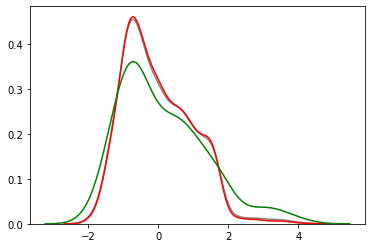

In [140]:
sns.distplot(X[:, 0], hist=False, color="grey")
sns.distplot(X_num[ y == 0, 0], hist=False, color="red")
sns.distplot(X_num[ y == 1, 0], hist=False, color="green")

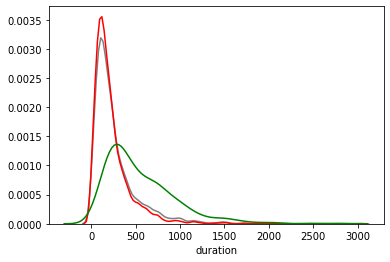

In [25]:
sns.distplot(bank['duration'], hist=False, color="grey")
sns.distplot(bank.loc[y == 0, 'duration'], hist=False, color="red")
sns.distplot(bank.loc[y == 1, 'duration'], hist=False, color="red")

In [26]:
bank.loc[y == 0, 'duration'].mean()

226.3475

In [27]:
bank.loc[y == 1, 'duration'].mean()

552.7428023032629

In [29]:
bank.loc[50, 'duration'], y[50]

(1018, 1)

In [31]:
from scipy.spatial.distance import euclidean as distance

In [39]:
def predict(x, pos_mean, neg_mean):
    return distance(x, pos_mean) < distance(x, neg_mean)

predict(bank['duration'].values, 
        bank.loc[y == 1, 'duration'].mean(), bank.loc[y == 0, 'duration'].mean())

False

# Preparation for Modelling

There's two times to consider:
    * training 
    * prediction time

Transormeations at trainitimg time will often have dual use at prediction time

eg., label encoder -- need to know the classes, so to display interprable ouptut 


### Label Encoding

In [42]:
from sklearn.preprocessing import LabelEncoder

In [45]:
LabelEncoder().fit_transform(bank['y'])

array([0, 0, 0, ..., 0, 0, 0])

In [95]:
lenc = LabelEncoder().fit(bank['y'])
y = lenc.transform(bank['y'])

In [44]:
lenc.classes_

array([0, 1], dtype=object)

### Scaling

* distanced based algorithms can be sentivie to high ratios in numeric cols when calcing distances, and therefore can be biased towards usoing *only* large value cols in their prediction rule



In [48]:
import sklearn.preprocessing as pre

In [51]:
[n for n in dir(pre) if not n.startswith('_')]

['Binarizer',
 'FunctionTransformer',
 'Imputer',
 'KBinsDiscretizer',
 'KernelCenterer',
 'LabelBinarizer',
 'LabelEncoder',
 'MaxAbsScaler',
 'MinMaxScaler',
 'MultiLabelBinarizer',
 'Normalizer',
 'OneHotEncoder',
 'OrdinalEncoder',
 'PolynomialFeatures',
 'PowerTransformer',
 'QuantileTransformer',
 'RobustScaler',
 'StandardScaler',
 'add_dummy_feature',
 'base',
 'binarize',
 'data',
 'imputation',
 'label',
 'label_binarize',
 'maxabs_scale',
 'minmax_scale',
 'normalize',
 'power_transform',
 'quantile_transform',
 'robust_scale',
 'scale']

In [60]:
mean_age = bank[['age']].mean()
std_age = bank[['age']].std()

(bank[['age']] - mean_age)/std_age

,age
0,-1.056153
1,-0.772497
2,-0.583394
3,-1.056153
4,1.685850
5,-0.583394
6,-0.488842
7,-0.205186
8,-0.016083
9,0.173021


At prediction time we will transofrm incoming features using the mean/std learnt... from *historical data*.

We *must* use historical means to transform... 
    * model will fail to generalize when mean changes
    * at prediction time the model is using trained historical parameters
        * so incoming features need to be transformed consistent with expercted input
        * ie., x must look like training x in *form*

In [55]:
sclr = pre.StandardScaler().fit(bank[ ['age', 'balance', 'day'] ])

In [73]:
X_num = sclr.transform(bank[ ['age', 'balance', 'day'] ])

In [75]:
oenc = pre.OrdinalEncoder().fit(bank[ ['education', 'job'] ])
X_ord = oenc.transform(bank[ ['education', 'job']])

In [66]:
oenc.categories_

[array(['primary', 'secondary', 'tertiary', 'unknown'], dtype=object),
 array(['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management',
        'retired', 'self-employed', 'services', 'student', 'technician',
        'unemployed', 'unknown'], dtype=object)]

enumerate pairs up values in a list with their indexes
and dict converts these pairs into a dictinry

In [72]:
dict(enumerate(oenc.categories_[0]))

{0: 'primary', 1: 'secondary', 2: 'tertiary', 3: 'unknown'}

In [76]:
X = np.c_[X_num, X_ord]
X.shape

(4521, 5)

In [77]:
X[0, :]

array([-1.05626965,  0.12107186,  0.37405206,  0.        , 10.        ])

In [80]:
bank.loc[0, 'age'] - bank.loc[1, 'age'] 

-3

In [81]:
bank.loc[0, 'balance'] - bank.loc[1, 'balance'] 

-3002

#### Should we scale all kinds of numeric colm?>

$ f(x) = 0.5e^{0.05x} $

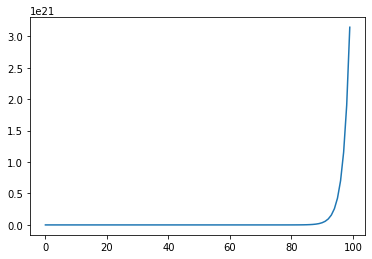

In [87]:
sns.lineplot(np.arange(100), np.exp(0.5 * np.arange(100)))

In [88]:
xt = np.exp(0.5 * np.arange(100))
(xt - xt.mean())/xt.std()

array([-0.20631996, -0.20631996, -0.20631996, -0.20631996, -0.20631996,
       -0.20631996, -0.20631996, -0.20631996, -0.20631996, -0.20631996,
       -0.20631996, -0.20631996, -0.20631996, -0.20631996, -0.20631996,
       -0.20631996, -0.20631996, -0.20631996, -0.20631996, -0.20631996,
       -0.20631996, -0.20631996, -0.20631996, -0.20631996, -0.20631996,
       -0.20631996, -0.20631996, -0.20631996, -0.20631996, -0.20631996,
       -0.20631996, -0.20631996, -0.20631996, -0.20631996, -0.20631996,
       -0.20631996, -0.20631996, -0.20631996, -0.20631996, -0.20631996,
       -0.20631996, -0.20631996, -0.20631996, -0.20631996, -0.20631996,
       -0.20631996, -0.20631996, -0.20631996, -0.20631996, -0.20631996,
       -0.20631996, -0.20631996, -0.20631996, -0.20631996, -0.20631996,
       -0.20631996, -0.20631995, -0.20631995, -0.20631995, -0.20631994,
       -0.20631993, -0.20631991, -0.20631988, -0.20631983, -0.20631975,
       -0.20631962, -0.2063194 , -0.20631904, -0.20631845, -0.20

---

In [94]:
y

array([0, 0, 0, ..., 0, 0, 0], dtype=object)

In [97]:
from sklearn.linear_model import LogisticRegression

LogisticRegression(solver='liblinear').fit(X, y).score(X, y)

0.8847600088476001

In [98]:
bank['y'].value_counts()

0    4000
1     521
Name: y, dtype: int64

In [105]:
import sklearn.neighbors as n

KNeighborsClassifier(1).fit(X, y).score(X, y)

0.9991152399911524

In [230]:
from sklearn.model_selection import train_test_split

def score(model, X, y):
    Xtr, Xte, ytr, yte = train_test_split(X, y, random_state=0)
    model = model.fit(Xtr, ytr)
    return (model , model.score(Xte, yte) )

In [231]:
score(KNeighborsClassifier(1), X, y)

(KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                      weights='uniform'), 0.812555260831123)

In [232]:
from sklearn.ensemble import RandomForestClassifier

score(RandomForestClassifier(n_estimators=100), X, y)

(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                        max_depth=None, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False), 0.8735632183908046)

### Problems with Ordinal Encoding

* loss magnitude biases training
    * loss(leeds, london) = 3
    * loss(leeds, manchester) = 10
        * alg will learn leeds closer to manchester

* at prediction time, some algs use distance
    * eg., find closest to leeds, get london
    * eg., find closest to london, get manchester
    

In [133]:
ohe = pre.OneHotEncoder(sparse=False).fit(bank[['job', 'education']])
X_oh = ohe.transform(bank[['job', 'education']])
X_oh[0, :]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.])

In [137]:
X_gd = np.c_[X_num, X_oh]

score(LogisticRegression(solver='liblinear'), X_gd, y)

(LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                    warm_start=False), 0.878868258178603)

### The General Appraoch

default approach to try first:

* StandardScalar for numeric
* OneHotEncode for categorical

### Aside: can the alg. unbias the input?

* to a degree
    * suppose we look at age/balance/y with linear regression
    * we learn w1 * age + w2 * balance
    * w1 will be learnt as, eg., 2 and w2 as eg., 0.02
    * so learning "scales" by parameter magnitude
    * but its hard(er) to learn these parameters and better to start with unbised data
        * why? consider small permutations in 2 make little difference, but small in 0.02 make big difference
        * hard to find minimum loss under such conditions

## Exercise

* Goal:
    * prepare every column of bank.csv for learning
    * try various encoding techniques:
        * Scaling, Ordinal, OneHot, Normalizing
    * score various models:
        * LogReg, KNN (EXTRA:, MLPClassifier)
        
    * what columns are the best, what classifier is the best?
    
* Concerns:
    * if your score is very high, have you made mistake?
        * eg., is your target column in your features list
    * if you score is very low, have you made a mistake?
        * eg., is your target column encoded the same way at prediction/training time
    * what's your base case accuracy?
    * think about what your doing

In [142]:
np.c_[
    np.array([1, 2, 3]),
    np.array([1, 2, 3]),
]

array([[1, 1],
       [2, 2],
       [3, 3]])

In [143]:
np.r_[
    np.array([1, 2, 3]),
    np.array([1, 2, 3]),
]

array([1, 2, 3, 1, 2, 3])

In [161]:
features.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
dtype: object

In [301]:
features = bank.drop(columns=['y'])
target = bank['y']
Xsc = pre.StandardScaler().fit_transform(features.select_dtypes(np.int64))
Xoh = pre.OneHotEncoder(sparse=False).fit_transform(features.select_dtypes(np.object))
# Xoh = pre.OrdinalEncoder().fit_transform(features.select_dtypes(np.object))
y_bank = pre.LabelEncoder().fit_transform(target)
X_bank = np.c_[Xsc, Xoh] 

## Exercise
* starting with a OneHotEncode'd feature space
* PCA this X, as below, keeping `n` columns
* try various classification algor. over this new X (call `X_pca`)

* at what number of columns do you start to get poor scores?
    * loosing info
* what is the best solution?

* EXTRA: using sklearn PCA docs, (or notes on Prep & Unsupervised Lerning)
    * plot the explained varience (as a cumulative sum)

In [302]:
from sklearn.decomposition import PCA

X_pca = PCA(3).fit_transform(X_bank)
score(LogisticRegression(solver='liblinear'), X_pca, y_bank)

(LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                    warm_start=False), 0.8779840848806366)

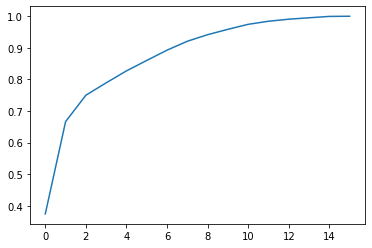

In [308]:
ev = pca.explained_variance_ratio_
sns.lineplot(range(len(ev)), np.cumsum(ev));

# High-Dimensional Features Spaces

* Either:
    *  reduce the number of features
        * compression ->
        * drop
    * select subset

### Choosing a subset of columns

* Why?
    * algorithms which use distance-based loss functions can struggle to learn in high-dim spaces
        * points distinct in 1D can be less distinct in 2D, etc.
        
* SelectKBest
    * aprox: compute a score for a column based on how much independent information it has
        * eg., rank according to how each pair of columns is correlated
        * keep *least* correlated columns, as points are most distinct in these
        * eg., (Age, Height, IQ) -- Age highly correlated with Hight
        * people most distinct in (Age, IQ) or (Height, IQ) -- third column isnt vital

In [205]:
from sklearn.feature_selection import SelectKBest

In [206]:
k10 = SelectKBest(k=4).fit(X_bank, y_bank)

In [207]:
k10.scores_

array([9.20707070e+00, 1.44922234e+00, 5.71419411e-01, 8.66505760e+02,
       1.69599922e+01, 4.94953804e+01, 6.24091442e+01, 3.39543524e+00,
       1.02269225e+00, 8.36596827e+00, 7.66832180e-03, 5.00706834e+01,
       2.25837165e+01, 8.21193103e+01, 7.58425183e+00, 3.10680609e+01])

In [208]:
tnames = np.r_[
    features.select_dtypes(np.int64).columns,
    features.select_dtypes(np.object).columns
]

In [209]:
sorted( list(zip(np.argsort(k10.scores_), tnames)), key=lambda e: e[0])

[(0, 'job'),
 (1, 'duration'),
 (2, 'balance'),
 (3, 'poutcome'),
 (4, 'marital'),
 (5, 'housing'),
 (6, 'contact'),
 (7, 'campaign'),
 (8, 'day'),
 (9, 'previous'),
 (10, 'age'),
 (11, 'loan'),
 (12, 'education'),
 (13, 'month'),
 (14, 'pdays'),
 (15, 'default')]

In [211]:
X_4best = k10.transform(X_bank)

In [244]:
score(LogisticRegression(solver='liblinear'), X_4best, y)

(LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                    warm_start=False), 0.887709991158267)

In [227]:
from sklearn.neural_network import MLPClassifier

In [228]:
score(MLPClassifier(hidden_layer_sizes=(1,), activation='logistic'), X_bank[:, :4], y)

(MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
               beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
               hidden_layer_sizes=(1,), learning_rate='constant',
               learning_rate_init=0.001, max_iter=200, momentum=0.9,
               n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
               random_state=None, shuffle=True, solver='adam', tol=0.0001,
               validation_fraction=0.1, verbose=False, warm_start=False),
 0.8753315649867374)

### Transforming Feature Space

* Space = axes = set of points
* Feature space = set of axes we use to measure x
    * all the possible options a given x can have
    
    
* goal:
    * new columns (new featuer space)
        * with same or *lower* information than the original
        * why less?
            * learning is difficult in high dimesnion

### Pricipal Component Analysis

In [267]:
X_old = np.array([
    [1 , 20.1],
    [3 , 36.2],
    [5 , 52.3]
])

## X_old

In [268]:
X_old[:, 0].reshape(-1, 1)

array([[1.],
       [3.],
       [5.]])

In [269]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression().fit(X_old[:, 0].reshape(-1, 1), X_old[:, 1])

In [274]:
s = lm.coef_[0]
i = lm.intercept_

In [271]:
8 * X_old[:, 0]  + 12

array([20., 36., 52.])

In [276]:
np.c_[
    X_old[:, 0],
    s * X_old[:, 0] + i
]

array([[ 1. , 20.1],
       [ 3. , 36.2],
       [ 5. , 52.3]])

In [279]:
from sklearn.decomposition import PCA

In [281]:
X_bank[:, 0]

array([-1.05626965, -0.77258281, -0.58345826, ...,  1.49691189,
       -1.24539421,  0.26760226])

In [290]:
pca = PCA().fit(X_bank)
pca.explained_variance_ratio_

array([0.37390942, 0.29218089, 0.08379541, 0.03917937, 0.03786515,
       0.0331003 , 0.0325554 , 0.02818523, 0.02083661, 0.01701098,
       0.01580281, 0.00973381, 0.00650297, 0.00452463, 0.00426775,
       0.00054928])

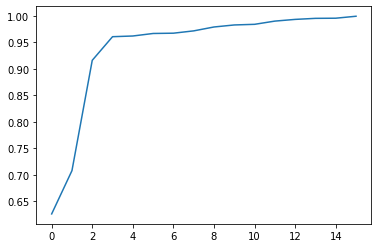

In [293]:
sns.lineplot(range(len(pca.explained_variance_ratio_)), 1-pca.explained_variance_ratio_)


In [322]:
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin

class Encode(TransformerMixin):
    def transform(self, X, y=None):
        return np.c_[
            self.scale.transform(X.values),
            self.hot.transform(X.values)
        ]
    
    def fit(self, X, y=None):
        self.scale = pre.StandardScaler().fit(X.select_dtypes(np.int64).values)
        self.hot = pre.OneHotEncoder().fit(X.select_dtypes(np.object).values)
        
        return X
    
    
prep = Pipeline([
    ('Encode', Encode()),
    ('Reduce', PCA(0.85)),
    ('Predict', LogisticRegression())
])

prep.fit(bank)


ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().